# **Suicide Risk Analysis - Module 2 Predictive Modeling using Machine Learning**



### Stages of the project

###This project is divided into two stages, as modules:

 **Module 1. Data availability and suitability assessment**

**Module 2. Predictive Modeling using Machine Learning**

**Module 3. Predictive Modeling using a Synthethic Dataset**

## Research Questions

There are some research questions formulated for this research. In the following sections of this notebook, it will be asessed if it is possible to answer those questions with the dataset, or we need a different approach:

These comparisons will be based on data collection from people who committed suicide after being discharged from hospital.

1. Are there statistically significant differences in suicide risk between patients with various types of mental disorders, and can these differences be used to inform targeted intervention strategies?

2. What are the main factors, including demographic and clinical variables, that contribute to the risk of suicide within a year after discharge among patients diagnosed with mental disorders?

3. How do different features or indicators related to mental health, such as depression severity, treatment adherence, or follow-up care, impact the risk of suicide after discharge?

4. Can machine learning models effectively predict the risk of suicide among patients with specific mental disorders, and if so, which models perform best in this context?


## Applications of Modeling and Machine Learning:

- Predicting missing or future data

Using statistical or machine learning models to predict missing values based on other data. We can use a time-series approach, a country-based model where we use simularity between countries to inform other countries missing data, or use k-nearest neighbors (KNN) or regression models to predict missing values based on available data from similar rows.
    

- Trend Analysis:

We can use time-series modeling or regression techniques to identify trends over time in mental health-related suicide rates. For example, we could analyze how mental health suicide rates have changed over time in different countries, or explore the impact of gender on these trends.

- Segmentation:

Clustering techniques like k-means or hierarchical clustering could be used to group countries with similar suicide rates or mental health disorder characteristics. This could help identify patterns or trends in countries with similar healthcare systems or demographics.

- Anomaly Detection:

Identify outliers or anomalies in the dataset. For example, we could detect periods where certain countries report significantly higher or lower suicide rates than expected, and investigate what factors (e.g., policy changes, healthcare interventions) may have influenced those rates.

- Predicting the Impact of Policy:

Using machine learning models, we could simulate how certain interventions (like changes in healthcare policy or mental health services) could affect suicide rates. This could involve causal inference or simulation modeling, where we model the effect of different interventions on the target variable.

- Risk Factor Identification:

Use regression models or machine learning classification techniques (e.g., decision trees, random forests) to identify key risk factors for higher suicide rates among people with mental health conditions. This could include country-specific factors like access to mental health services, socioeconomic status, or gender disparities.

## Loading the datasets

In [ ]:
#importing required libraries
import numpy as np
import pandas as pd                     # data processing, CSV file
# Set the number of max columns and rows that can be visualized:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt           #visualisation
%matplotlib inline

import seaborn as sns                     #visualisation
sns.set(color_codes=True)
sns.set(style = 'dark')                   #sns.set(style="darkgrid") also available

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing dataset and examining it
# Read in the data
#data = pd.read_csv("/content/_HEALTH_HCQI_.csv")

# Loading data into data frame (If the data is in .config folder)
#data = pd.read_csv("/content/.config/content_HEALTH_HCQI_.csv", encoding="latin-1")     # encoding in latin-1 do not work good. it is better in utf-8
#data = pd.read_csv("/content/.config/content_HEALTH_HCQI_.csv.csv")

dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Suicide Prevention/_HEALTH_HCQI_.csv", usecols=['Country', 'Periods', 'IND', 'Gender', 'VAL', 'Value.1'])
dataset.head(5)

,Country,Periods,IND,Gender,VAL,Value.1
0,Czech Republic,2009,MORTSUMD,Total,AS_STD_RATE_CPAT,0.30
1,Czech Republic,2009,MORTSUMD,Total,LOW_CI,0.25
2,Czech Republic,2009,MORTSUMD,Total,UP_CI,0.34
3,Czech Republic,2010,MORTSUMD,Total,AS_STD_RATE_CPAT,0.29
4,Czech Republic,2010,MORTSUMD,Total,LOW_CI,0.25


#### Data Processing



In [ ]:
# Using a list of countries ordered by GDP, it is possible to create ordered categories useful for plotting and showing the differences in the countries based on GDP
# Convert the values of the variables to numeric data. Remember that Value is the name of the variable and Value.1 is the numeric value of the datapoint
dataset['Value.1'] = pd.to_numeric(dataset['Value.1'], errors='coerce')
# Sort the countries alphabetically into a categorical variable
dataset['Country'] = dataset['Country'].astype('category')
dataset['Country'] = dataset['Country'].cat.reorder_categories(sorted(dataset['Country'].unique()))
# Sort the countries by similarity, using the GDP index
my_order = ["Norway","Denmark","Netherlands","Iceland","Sweden","Finland","Canada","Malta","United Kingdom","New Zealand","Korea","Slovenia","Czech Republic","Israel","Lithuania","Latvia","Slovak Republic","Chile","Colombia"]
dataset['Country'] = dataset['Country'].cat.reorder_categories(my_order, ordered=True)

In [ ]:
# Variables in "IND"/"Indicator" and "VAL'/"Value" have to be separated in different columns?
wide_dataset = dataset.pivot(index=['Country', 'Periods', 'Gender'], columns=['IND', 'VAL'], values='Value.1').reset_index()

#we can flatten the multiindex replacing it for a concatenation (Join) of the different levels of index, for each column. This is done with a list comprehension
wide_dataset.columns = [''.join(col) for col in wide_dataset.columns]        # or alternatively: [' '.join(col).strip() for col in df.columns.values]

# Reorder the columns
wide_dataset.columns = ['Country', 'Periods', 'Gender',
                         'EXCESCHIAS_STD_RATIO',       # Excess mortality for patients diagnosed with bipolar disorder, Age-sex standardised ratio
                         'EXCEBIPOAS_STD_RATIO',       # Excess mortality for patients diagnosed with bipolar disorder, Age-sex standardised ratio
                         'MORTSUMDAS_STD_RATE_CPAT',   # Mortality Rate of Suicide within 1 year after discharge among patients diagnosed with a mental disorder, Age-sex standardised rate per 100 patients
                         'MORTSUMDLOW_CI',             # Mortality Rate of Suicide in people with mental disorder, 1Y after discharge, Lower confidence interval
                         'MORTSUMDUP_CI',              # Mortality Rate of Suicide in people with mental disorder, 1Y after discharge, Upper confidence interval
                         'MORTSUMSAS_STD_RATE_CPAT',   # Mortality Rate of Suicide within 30 days after discharge among patients diagnosed with a mental disorder, Age-sex standardised rate per 100 patients
                         'MORTSUMSLOW_CI',             # Mortality Rate of Suicide in people with mental disorder, 30d after discharge, Lower confidence interval
                         'MORTSUMSUP_CI']              # Mortality Rate of Suicide in people with mental disorder, 30d after discharge, Upper confidence interval

In [ ]:
# melt the wide dataset in order to have a long dataset again, but with the missing values:
long_dataset = pd.melt(wide_dataset,
                       id_vars=['Country', 'Periods', 'Gender'],
                       value_vars=['EXCESCHIAS_STD_RATIO', 'EXCEBIPOAS_STD_RATIO', 'MORTSUMDAS_STD_RATE_CPAT', 'MORTSUMDLOW_CI', 'MORTSUMDUP_CI', 'MORTSUMSAS_STD_RATE_CPAT', 'MORTSUMSLOW_CI', 'MORTSUMSUP_CI'],
                       var_name='IND',
                       value_name='Valuee',
                       ignore_index=True)
long_dataset.head()

,Country,Periods,Gender,IND,Valuee
0,Norway,2012,Female,EXCESCHIAS_STD_RATIO,NaN
1,Norway,2012,Male,EXCESCHIAS_STD_RATIO,NaN
2,Norway,2012,Total,EXCESCHIAS_STD_RATIO,NaN
3,Norway,2013,Female,EXCESCHIAS_STD_RATIO,NaN
4,Norway,2013,Male,EXCESCHIAS_STD_RATIO,NaN


In [ ]:
# I renamed de column,Value.1 to Valuee because there was string.
dataset.rename(columns={'Value.1': 'Valuee'}, inplace=True)

In [ ]:
# Combine both columns into a new one
dataset['IND'] = dataset['IND'].astype(str) + "_" + dataset['VAL'].astype(str)

# Convert the new column to a categorical variable
dataset['IND'] = pd.Categorical(dataset['IND'])

dataset = dataset.drop(columns=['VAL'])

dataset.head()

,Country,Periods,IND,Gender,Valuee
0,Czech Republic,2009,MORTSUMD_AS_STD_RATE_CPAT,Total,0.30
1,Czech Republic,2009,MORTSUMD_LOW_CI,Total,0.25
2,Czech Republic,2009,MORTSUMD_UP_CI,Total,0.34
3,Czech Republic,2010,MORTSUMD_AS_STD_RATE_CPAT,Total,0.29
4,Czech Republic,2010,MORTSUMD_LOW_CI,Total,0.25


# **Module 2. Predicting Values using Neural Networks**

## Filling Missing Data in the Dataset:
Should we fill missing data?

The decision to fill missing data depends on several factors, including the context of the dataset and how the missing data might affect the analysis. Here's a breakdown:

**When it's appropriate to fill missing data:**

- If the data is missing at random (i.e., there's no specific pattern to which data is missing, and it doesn't correlate with any of the other variables), it may make sense to fill in missing values. We can do this by:
    - Imputing with the mean/median: This is common when the missing data is numerical and we want to avoid losing too many observations.
    - Imputing with prediction models: Using statistical or machine learning models (such as regression or k-nearest neighbors) to predict missing values based on other data.

**When it's inappropriate to fill missing data:**

- If the data is missing not at random (i.e., there's a systematic reason why certain countries or periods have missing data), filling the data could introduce bias.
- If filling in the data would distort the reality of the situation, especially in cases where the missing data is due to a lack of reporting or lack of relevance in the context.

**Impact of missing data:**

Analysis integrity: Imputing missing data can introduce bias, especially if the missingness is not random. In cases like medical or mental health data, it's important to understand why certain data points are missing, as they could be indicative of reporting issues.

Alternative: Rather than filling in missing data, we might also consider excluding missing values if they are a small fraction, or using specialized techniques like multiple imputation to preserve variability.

In [ ]:
# Eliminate the datapoints representing "Totals" in the variable Gender
dataset = long_dataset[long_dataset.Gender != "Total"]

In [ ]:
# Categorical variables like Country and Gender should be encoded appropriately for use in machine learning models (e.g., label encoding or one-hot encoding).
# Label Encoding (for ordinal categories like Countries ordered by GDP)
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the 'Gender' column using One-hot encoding
dataset = pd.get_dummies(dataset, columns=['Gender'], drop_first=True)

# Encode the 'Country' column using Label encoding
dataset['COU'] = label_encoder.fit_transform(dataset['Country'])

# Ensure the 'Periods' column is sorted numerically (And country, as countries are ordered by GDP)
dataset = dataset.sort_values(by=['IND', 'Gender_Male', 'Country', 'Periods'])

dataset.head()

,Country,Periods,IND,Valuee,Gender_Male,COU
798,Norway,2012,EXCEBIPOAS_STD_RATIO,NaN,False,14
801,Norway,2013,EXCEBIPOAS_STD_RATIO,NaN,False,14
804,Norway,2014,EXCEBIPOAS_STD_RATIO,NaN,False,14
807,Norway,2015,EXCEBIPOAS_STD_RATIO,NaN,False,14
810,Norway,2016,EXCEBIPOAS_STD_RATIO,NaN,False,14


In [ ]:
# Check the number of datapoints in the dataset
dataset.groupby(['IND', 'Country']).agg('count')

<ipython-input-164-347b12a3603f>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Periods  Valuee  Gender_Male  COU
IND                      Country                                           
EXCEBIPOAS_STD_RATIO     Norway                20       4           20   20
                         Denmark               36      36           36   36
                         Netherlands           18      16           18   18
                         Iceland               46      42           46   46
                         Sweden                44      44           44   44
                         Finland               34      34           34   34
                         Canada                36       8           36   36
                         Malta                 10      10           10   10
                         United Kingdom        14      14           14   14
                         New Zealand           32      28           32   32
                         Korea                 28      22           28   28
                         Slovenia              18      18           18   18
                         Czech Republic        26      26           26   26
                         Israel                46      40           46   46
                         Lithuania             42      20           42   42
                         Latvia                24      20           24   24
                         Slovak Republic       10      10           10   10
                         Chile                 30      28           30   30
                         Colombia              18      18           18   18
EXCESCHIAS_STD_RATIO     Norway                20       4           20   20
                         Denmark               36      36           36   36
                         Netherlands           18      16           18   18
                         Iceland               46      42           46   46
                         Sweden                44      44           44   44
                         Finland               34      34           34   34
                         Canada                36       8           36   36
                         Malta                 10      10           10   10
                         United Kingdom        14      14           14   14
                         New Zealand           32      28           32   32
                         Korea                 28      22           28   28
                         Slovenia              18      18           18   18
                         Czech Republic        26      26           26   26
                         Israel                46      40           46   46
                         Lithuania             42      20           42   42
                         Latvia                24      20           24   24
                         Slovak Republic       10      10           10   10
                         Chile                 30      28           30   30
                         Colombia              18      18           18   18
MORTSUMDAS_STD_RATE_CPAT Norway                20       4           20   20
                         Denmark               36      36           36   36
                         Netherlands           18      16           18   18
                         Iceland               46      42           46   46
                         Sweden                44      44           44   44
                         Finland               34      34           34   34
                         Canada                36       8           36   36
                         Malta                 10      10           10   10
                         United Kingdom        14      14           14   14
                         New Zealand           32      28           32   32
                         Korea                 28      22           28   28
                         Slovenia              18      18           18   18
                         Czech Republic        26      26           26   26
              

### Time-Series Approach to predict missing values (A bad Idea)

For time-series analysis, especially when dealing with variables measured over time (e.g., years), the long-format dataset is preferred. It allows for a time-series model to easily analyze each country’s data over time and apply techniques like lagging features or rolling averages.

In [ ]:
# Linear interpolation estimates missing values based on the surrounding values in the dataset. It assumes that the missing data points fall on a linear scale between the available data points.
dataset['Value_TS_Interpolated'] = dataset.groupby(['IND', 'Country'])['Valuee'].transform(lambda x: x.interpolate())

<ipython-input-165-87fa56aa810b>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
# We run it again, in order to interpolate over the interpolated data... so we have much more fake data, but less missing data, HAHAHA (No it doesnt work like that)
dataset['Value_TS_Interpolated'] = dataset.groupby(['Gender_Male', 'IND'])['Value_TS_Interpolated'].transform(lambda x: x.interpolate())

In [ ]:
# Create the new column based on 'value' column
dataset['status'] = dataset['Valuee'].apply(lambda x: 'interpolated' if pd.isna(x) else 'original')
#dataset[dataset['status']=='interpolated']['status'] = dataset[dataset['status']=='interpolated']['Value_TS_Interpolated'].apply(lambda x: np.nan if pd.isna(x) else 'interpolated')
# Convert to categorical
dataset['status'] = pd.Categorical(dataset['status'])
# dataset['status'].value_counts()

In [ ]:
# Check the number of datapoints in the dataset after inputting values
dataset.groupby(['IND', 'Country']).agg('count')

<ipython-input-182-2eb1ea8c0b26>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Periods  Valuee  Gender_Male  COU  \
IND                      Country                                              
EXCEBIPOAS_STD_RATIO     Norway                20       4           20   20   
                         Denmark               36      36           36   36   
                         Netherlands           18      16           18   18   
                         Iceland               46      42           46   46   
                         Sweden                44      44           44   44   
                         Finland               34      34           34   34   
                         Canada                36       8           36   36   
                         Malta                 10      10           10   10   
                         United Kingdom        14      14           14   14   
                         New Zealand           32      28           32   32   
                         Korea                 28      22           28   28   
                         Slovenia              18      18           18   18   
                         Czech Republic        26      26           26   26   
                         Israel                46      40           46   46   
                         Lithuania             42      20           42   42   
                         Latvia                24      20           24   24   
                         Slovak Republic       10      10           10   10   
                         Chile                 30      28           30   30   
                         Colombia              18      18           18   18   
EXCESCHIAS_STD_RATIO     Norway                20       4           20   20   
                         Denmark               36      36           36   36   
                         Netherlands           18      16           18   18   
                         Iceland               46      42           46   46   
                         Sweden                44      44           44   44   
                         Finland               34      34           34   34   
                         Canada                36       8           36   36   
                         Malta                 10      10           10   10   
                         United Kingdom        14      14           14   14   
                         New Zealand           32      28           32   32   
                         Korea                 28      22           28   28   
                         Slovenia              18      18           18   18   
                         Czech Republic        26      26           26   26   
                         Israel                46      40           46   46   
                         Lithuania             42      20           42   42   
                         Latvia                24      20           24   24   
                         Slovak Republic       10      10           10   10   
                         Chile                 30      28           30   30   
                         Colombia              18      18           18   18   
MORTSUMDAS_STD_RATE_CPAT Norway                20       4           20   20   
                         Denmark               36      36           36   36   
                         Netherlands           18      16           18   18   
                         Iceland               46      42           46   46   
                         Sweden                44      44           44   44   
                         Finland               34      34           34   34   
                         Canada                36       8           36   36   
                         Malta                 10      10           10   10   
                         United Kingdom        14      14           14   14   
                         New Zealand           32      28           32   32   
                         Korea                 28      22           28   28   
             

In [ ]:
dataset.head(200)

,Country,Periods,IND,Valuee,Gender_Male,COU,Value_TS_Interpolated,status
798,Norway,2012,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,interpolated
801,Norway,2013,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,interpolated
804,Norway,2014,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,interpolated
807,Norway,2015,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,interpolated
810,Norway,2016,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,interpolated
813,Norway,2017,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,interpolated
816,Norway,2018,EXCEBIPOAS_STD_RATIO,0.57,False,14,0.570000,original
819,Norway,2019,EXCEBIPOAS_STD_RATIO,0.32,False,14,0.320000,original
822,Norway,2020,EXCEBIPOAS_STD_RATIO,NaN,False,14,0.375556,interpolated
825,Norway,2021,EXCEBIPOAS_STD_RATIO,NaN,False,14,0.431111,interpolated


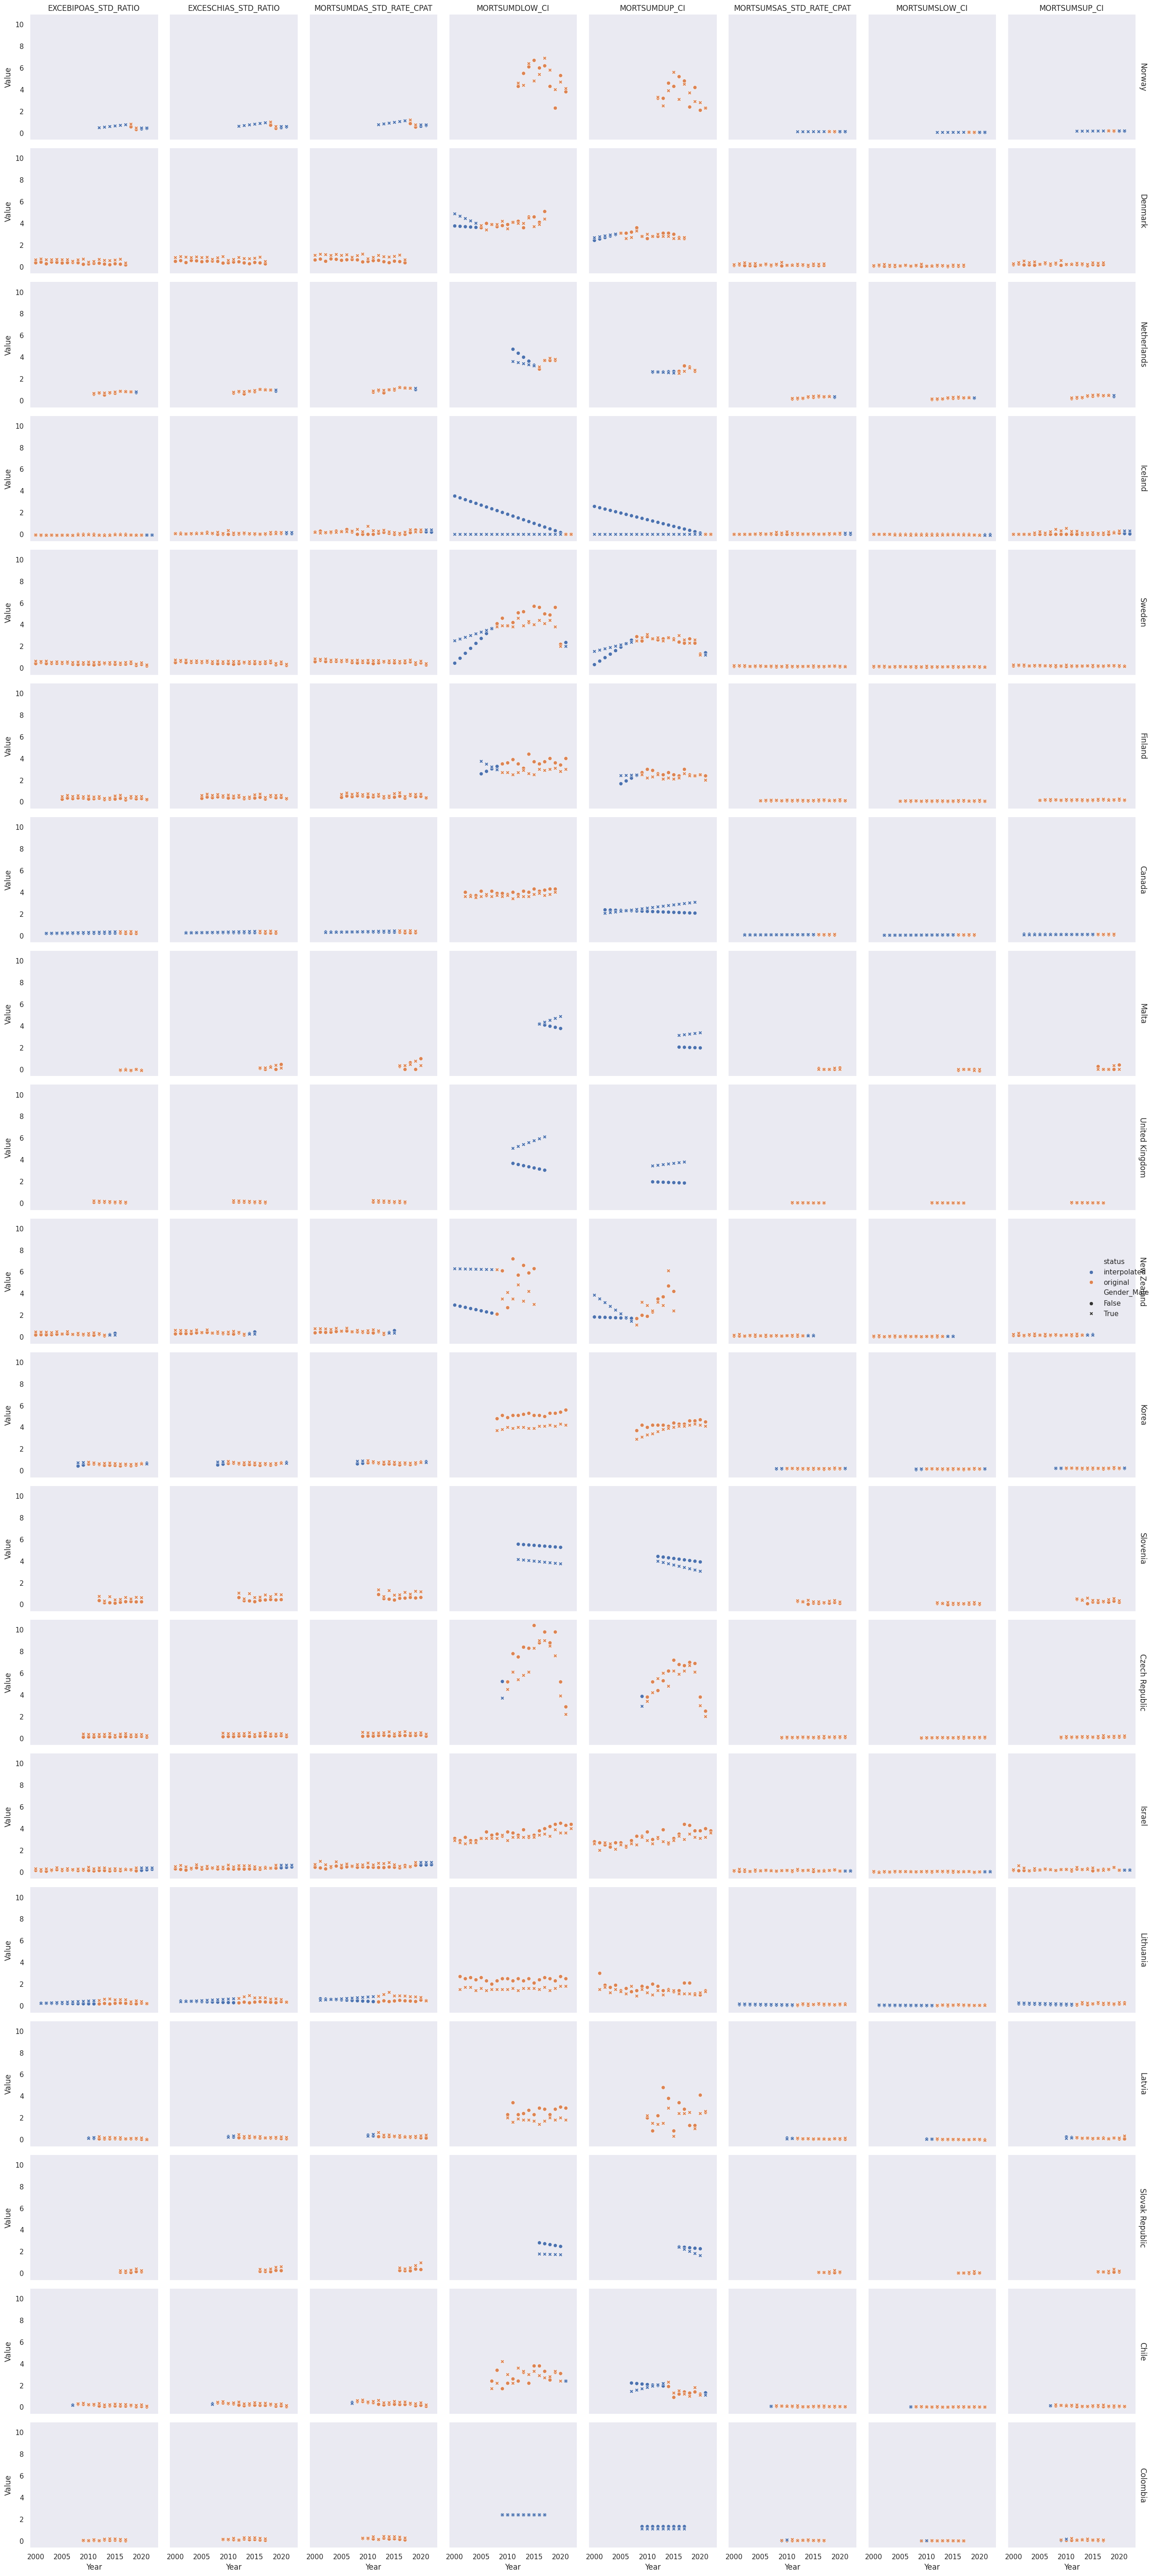

In [ ]:
# FacetGrid for plotting each variable by COU, GEN, or Gender, original values are orange and interpolated values are blue. male and female are differenced by markers.
g = sns.FacetGrid(dataset, col="IND", row="Country", margin_titles=True)
g.map(sns.scatterplot, 'Periods', 'Value_TS_Interpolated', style="Gender_Male", hue='status', data = dataset)


# Set titles and labels for the axes
g.set_axis_labels('Year', 'Value')
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a legend to differentiate between 'Original' and 'Interpolated'
g.add_legend()

# Display the plot
plt.tight_layout()
plt.show()

### Creating a Synthetic Value (e.g., Mean or Median)

if the missing data is not too large in proportion, we can impute missing values using the mean or median of the available data for each country or variable.

In [ ]:
# Impute with the mean for each Country and VAL
dataset['Value_Median'] = dataset.groupby(['Country', 'IND'])['Valuee'].transform(lambda x: x.fillna(x.mean()))

<ipython-input-181-0267a36d3898>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
# Check the number of datapoints in the dataset after inputting values
dataset.groupby(['IND', 'Country']).agg('count')

<ipython-input-184-2eb1ea8c0b26>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Periods  Valuee  Gender_Male  COU  \
IND                      Country                                              
EXCEBIPOAS_STD_RATIO     Norway                20       4           20   20   
                         Denmark               36      36           36   36   
                         Netherlands           18      16           18   18   
                         Iceland               46      42           46   46   
                         Sweden                44      44           44   44   
                         Finland               34      34           34   34   
                         Canada                36       8           36   36   
                         Malta                 10      10           10   10   
                         United Kingdom        14      14           14   14   
                         New Zealand           32      28           32   32   
                         Korea                 28      22           28   28   
                         Slovenia              18      18           18   18   
                         Czech Republic        26      26           26   26   
                         Israel                46      40           46   46   
                         Lithuania             42      20           42   42   
                         Latvia                24      20           24   24   
                         Slovak Republic       10      10           10   10   
                         Chile                 30      28           30   30   
                         Colombia              18      18           18   18   
EXCESCHIAS_STD_RATIO     Norway                20       4           20   20   
                         Denmark               36      36           36   36   
                         Netherlands           18      16           18   18   
                         Iceland               46      42           46   46   
                         Sweden                44      44           44   44   
                         Finland               34      34           34   34   
                         Canada                36       8           36   36   
                         Malta                 10      10           10   10   
                         United Kingdom        14      14           14   14   
                         New Zealand           32      28           32   32   
                         Korea                 28      22           28   28   
                         Slovenia              18      18           18   18   
                         Czech Republic        26      26           26   26   
                         Israel                46      40           46   46   
                         Lithuania             42      20           42   42   
                         Latvia                24      20           24   24   
                         Slovak Republic       10      10           10   10   
                         Chile                 30      28           30   30   
                         Colombia              18      18           18   18   
MORTSUMDAS_STD_RATE_CPAT Norway                20       4           20   20   
                         Denmark               36      36           36   36   
                         Netherlands           18      16           18   18   
                         Iceland               46      42           46   46   
                         Sweden                44      44           44   44   
                         Finland               34      34           34   34   
                         Canada                36       8           36   36   
                         Malta                 10      10           10   10   
                         United Kingdom        14      14           14   14   
                         New Zealand           32      28           32   32   
                         Korea                 28      22           28   28   
             

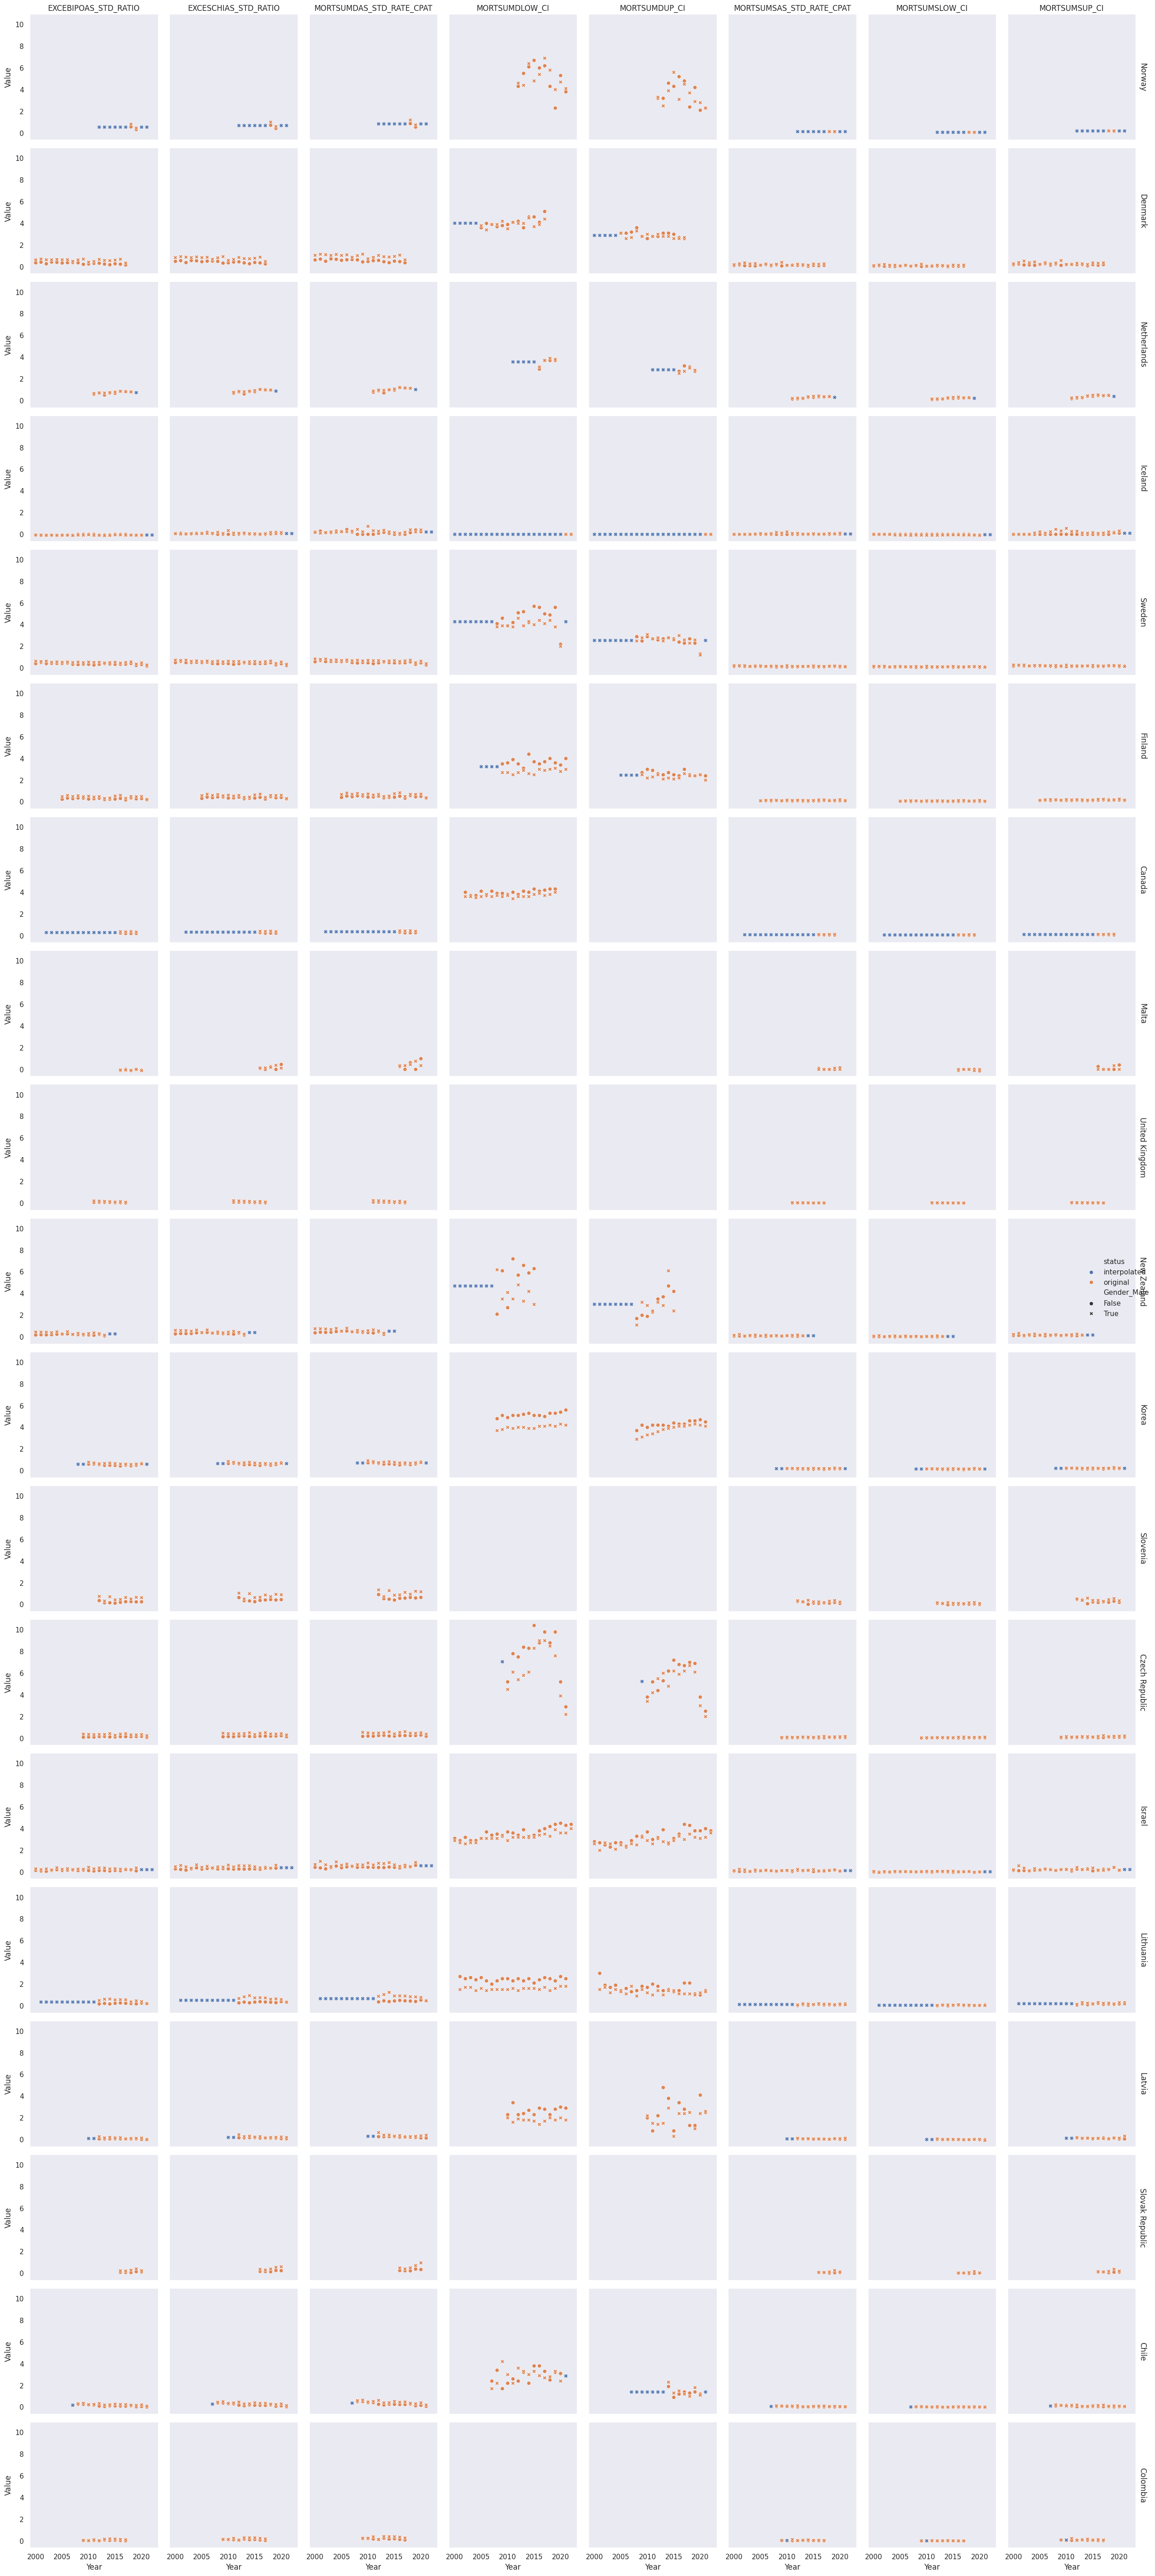

In [ ]:
# FacetGrid for plotting each variable by COU, GEN, or Gender, original values are orange and interpolated values are blue. male and female are differenced by markers.
g = sns.FacetGrid(dataset, col="IND", row="Country", margin_titles=True)
g.map(sns.scatterplot, 'Periods', 'Value_Median', style="Gender_Male", hue='status', data = dataset)


# Set titles and labels for the axes
g.set_axis_labels('Year', 'Value')
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a legend to differentiate between 'Original' and 'Interpolated'
g.add_legend()

# Display the plot
plt.tight_layout()
plt.show()

### Imputation Using Statistical Models (e.g., Regression)

train a regression model to predict the missing value of a variable (like Valuee) based on the other features in the dataset (e.g., Gender, Country, Period, or other variables).

In [ ]:
dataset['Value_SM_Inputted'] = dataset.Valuee
dataset.head()

,Country,Periods,IND,Valuee,Gender_Male,COU,Value_TS_Interpolated,Value_SM_Inputted
798,Norway,2012,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,NaN
801,Norway,2013,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,NaN
804,Norway,2014,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,NaN
807,Norway,2015,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,NaN
810,Norway,2016,EXCEBIPOAS_STD_RATIO,NaN,False,14,NaN,NaN


In [ ]:
from sklearn.linear_model import LinearRegression

# Assuming 'dataset' has missing 'Valuee' that we want to impute in a new attribute 'Value_SM_Inputted'

train_data = dataset.dropna(subset=['Value_SM_Inputted'])
X_train = train_data[['Country', 'Gender_Male', 'Periods']]  # Use other features for prediction
y_train = train_data['Value_SM_Inputted']

# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
missing_data = dataset[dataset['Value_SM_Inputted'].isna()]
X_missing = missing_data[['Country', 'Gender_Male', 'Periods']]
predicted_values = model.predict(X_missing)

# Fill the missing values
dataset.loc[dataset['Value_SM_Inputted'].isna(), 'Value_SM_Inputted'] = predicted_values

### ARIMA (AutoRegressive Integrated Moving Average)

### LSTM (Long Short-Term Memory) networks

Using Modeling to Predict Missing Data:

Yes, it is possible to use modeling to predict missing values. Here's a general framework on how to approach it:
Steps to Predict Missing Data:

    Explore the Missing Data:
        Identify the missing data pattern. Are certain columns consistently missing for specific countries or periods? This helps in understanding the nature of missingness.

    Choose an Imputation Method:
        If missing data is spread across different periods, a time-series approach could be helpful (for example, using data from previous or future years to predict current missing values).
        If missing values are for specific countries, a country-based model can be built (e.g., using data from countries with similar suicide rates or mental health conditions).
        we can also use k-nearest neighbors (KNN) or regression models to predict missing values based on available data from similar rows.

    Model Selection:
        Use machine learning algorithms (like decision trees, random forests, or k-nearest neighbors) to predict missing values. These models can be trained on the rows with complete data and used to estimate the missing values for other rows.

    Cross-validation:
        Split our data into training and validation sets to assess how well our model performs in predicting missing values. This will help we verify if the imputed values make sense.

    Impute the Missing Data:
        After building the model, we can fill the missing values in our dataset using the predicted values.

    Check for Bias:
        After imputation, ensure that the predictions do not introduce significant bias into our analysis. we might want to evaluate the imputed values' impact on the statistical properties of our dataset.

Considerations:

    Time series forecasting: If you're interested in predicting future trends or filling missing data based on past trends, techniques like ARIMA (AutoRegressive Integrated Moving Average) or LSTM (Long Short-Term Memory) networks might be useful for time-based predictions.
    Validation: It's important to validate the imputed values. If the imputation model overestimates or underestimates certain trends, it could distort our analysis, particularly for policy or public health recommendations.

##**Final Conclusion:**
In this project, learn how to work with different machine learning models on a set of data and understand their parameters. Creating this notebook helped me learn a lot about model parameters, how to tune them, and how they affect model performance. The final conclusion from the suicide dataset is that, regardless of age group and generation, the male population in each country is more likely to commit suicide than the female population.